In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy.spatial import distance
import csv
from pyspark.sql import SQLContext
from pyspark import SparkContext, SparkConf
import sys
import psycopg2
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [6]:
con=psycopg2.connect(dbname= 'genting', host='host_name',port= 5439, 
    user= 'user_id', password='password')
cur = con.cursor()
cur.execute("SELECT * FROM temp.customers_dormancy_data_all;") #table name
overall = 
train = pd.DataFrame((cur.fetchall()),
                   columns = ['customer_id','city_id','current_order_date','next_order_date','duration_min_current_ord',
                              'dormancy', 'dormant','ordered_days_p30d','orders_p30d','rev_p30d','subs_p30d','rev_porder_p30d',
'products_porder_p30d','ordered_days_pa2m','orders_pa2m','rev_pa2m','subs_pa2m','rev_porder_pa2m','products_porder_pa2m'])

In [113]:
con=psycopg2.connect(dbname= 'genting', host='host_name',port= 5439, 
    user= 'user_id', password='password')
cur = con.cursor()
cur.execute("SELECT distinct customer_id FROM temp.hack_data_sri;") #table name
customers = pd.DataFrame((cur.fetchall()),columns = ['customer_id'])

In [8]:
train.head()
train_bckup = train
trash = train[train['orders_pa2m'].isnull()]
train = train[~train['orders_pa2m'].isnull()]

In [10]:
train['products_porder_pa2m']=train['products_porder_pa2m'].convert_objects(convert_numeric=True)
train['products_porder_p30d']=train['products_porder_p30d'].convert_objects(convert_numeric=True)
train['city_id']=train.city_id.astype('category')

c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific convert

In [26]:
one_hot = pd.get_dummies(train['city_id'])
train = train.join(one_hot)
train.dtypes
#train = train.drop('city_id',axis = 1)
target = 'dormant'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train, train['dormant'], test_size=0.30, random_state=42, stratify=train['dormant'])

In [17]:
predictors = [x for x in train.columns if x not in ['customer_id','city_id','dormant','current_order_date', 'next_order_date']]
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=15, min_child_weight=3,
                       gamma=0.5, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,
                       scale_pos_weight=3.18, seed=42)

In [37]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds) # show_progress=True
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['dormant'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.2g" % metrics.accuracy_score(dtrain['dormant'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['dormant'], dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 1
AUC Score (Train): 1.000000


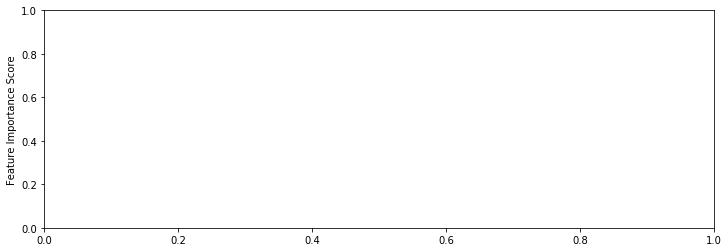

In [38]:
#predictors #X_train.head() #
modelfit(xgb1, X_train, predictors)

In [40]:
param_test1 = {'max_depth':range(3,15,2), 'min_child_weight':range(1,9,2)}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=140, max_depth=15,
        min_child_weight=3, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
        param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train[predictors],X_train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_s

({'mean_fit_time': array([2.25050507, 2.11938014, 2.2565012 , 2.24690714, 2.63148499,
         2.60430093, 2.52914419, 2.45038943, 2.92051983, 2.85415702,
         2.80498505, 2.83656731, 3.40324168, 3.26472054, 2.92511692,
         2.8951334 , 3.42822642, 3.17956972, 3.08462448, 3.04804544,
         3.70366845, 3.43022594, 3.28091173, 3.14159203]),
  'std_fit_time': array([0.24042625, 0.04303141, 0.07414472, 0.03294409, 0.05284328,
         0.02203527, 0.05612324, 0.01685871, 0.02767782, 0.05248435,
         0.03965855, 0.1075197 , 0.16101004, 0.10615556, 0.08045569,
         0.07572112, 0.09316757, 0.0398896 , 0.09950694, 0.06012328,
         0.13131645, 0.05024062, 0.0222172 , 0.06182129]),
  'mean_score_time': array([0.01159315, 0.01219349, 0.01479182, 0.01299329, 0.01199336,
         0.01299238, 0.01219239, 0.01299233, 0.01319189, 0.01359363,
         0.01199398, 0.01319213, 0.01639104, 0.0165906 , 0.01439261,
         0.01559157, 0.01319356, 0.01479163, 0.01699076, 0.01319256,
  

In [53]:
param_test2b = {
 'min_child_weight':[2,4,6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.05, n_estimators=140, max_depth=11,
 min_child_weight=2, gamma=0.5, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=3.18,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train[predictors],X_train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.05,
       max_delta_step=0, max_depth=11, min_child_weight=2, missing=None,
       n_estimators=140, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=3.18,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [2, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.72
AUC Score (Train): 0.716313


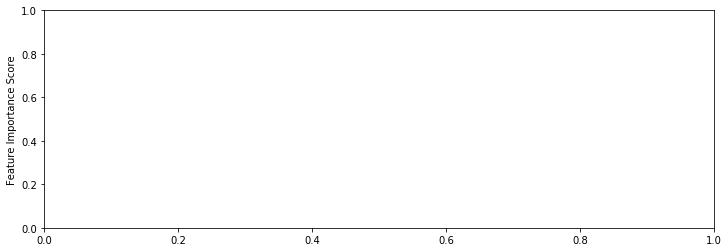

In [54]:
modelfit(gsearch2b.best_estimator_, X_train, predictors)
#gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [59]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=11,
     min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
     objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
     param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train[predictors],X_train[target])


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.79
AUC Score (Train): 0.669083


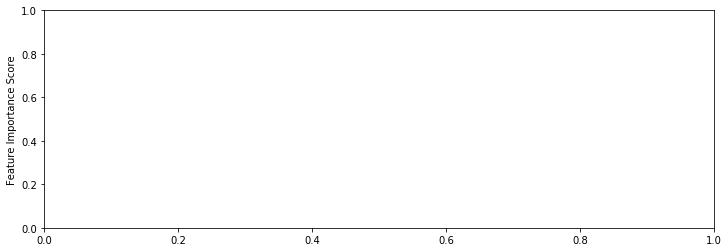

In [62]:
modelfit(gsearch3.best_estimator_, X_train, predictors)
#gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_


Model Report
Accuracy : 0.72
AUC Score (Train): 0.704297


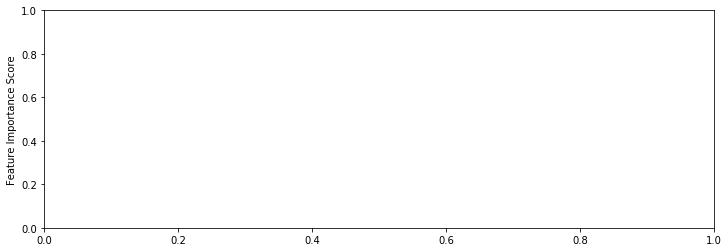

In [65]:
xgb2 = XGBClassifier(
 learning_rate =0.05, n_estimators=1000, max_depth=11, min_child_weight=2, gamma=0,subsample=0.8,
 colsample_bytree=0.8, objective= 'binary:logistic',
 nthread=4, scale_pos_weight=3.18, seed=27)
modelfit(xgb2, X_train, predictors)

In [67]:
# param_test4 = {
#  'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=177, max_depth=11,
#  min_child_weight=11, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=3.18,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train[predictors],X_train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=11, min_child_weight=11, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=3.18, seed=27,
       silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.8
AUC Score (Train): 0.729457


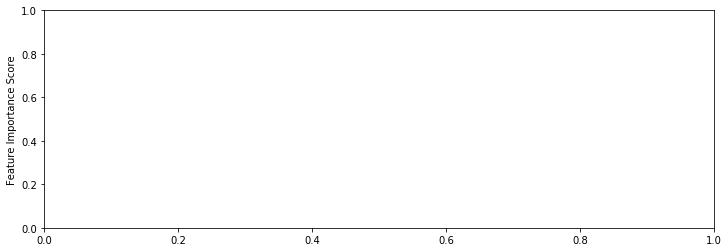

In [87]:
xgb4 = XGBClassifier(learning_rate =0.01, n_estimators=5000, max_depth=17, min_child_weight=2, gamma=0.05, subsample=0.8,
                colsample_bytree=0.8, reg_alpha=0.05, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb4, X_train, predictors)


Model Report
Accuracy : 1
AUC Score (Train): 1.000000


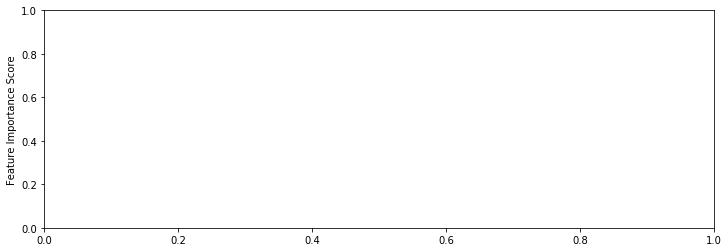

In [88]:
modelfit(xgb4, X_test, predictors)

In [122]:
#dtrain_predictions = xgb4.predict(X_train[predictors])
dtrain_predprob = xgb2.predict_proba(X_train[predictors])[:,1]
dtest_predprob = xgb2.predict_proba(X_test[predictors])[:,1]

In [125]:
#dtest_predprob

0.4767711

In [92]:
X_train[predictors].head()

duration_min_current_ord  dormancy  ordered_days_p30d  orders_p30d  \
21347                       370        21                  3            3   
24100                       119        23                 12           12   
4664                        142        19                  3            3   
10927                       148        22                 20           20   
11017                       205        21                  8            8   

       rev_p30d  subs_p30d  rev_porder_p30d  products_porder_p30d  \
21347    599.40          0       199.800000              2.000000   
24100   1191.01          0        99.250833              2.833333   
4664     897.40          0       299.133333              7.333333   
10927   1811.22         37        90.561000              2.900000   
11017    925.88          0       115.735000              4.500000   

       ordered_days_pa2m  orders_pa2m    rev_pa2m  subs_pa2m  rev_porder_pa2m  \
21347                 18         18.0   1456.3100        0.0        80.906111   
24100                 18         18.0   2574.9100        0.0       143.050556   
4664                  12         12.0  10798.8463        0.0       899.903858   
10927                 29         29.0   2625.8200       51.0        90.545517   
11017                  2          2.0    122.6920        0.0        61.346000   

       products_porder_pa2m  1120112  1120224  1120336  1120560  1120672  \
21347              2.111111        1        0        0        0        0   
24100              5.388889        1        0        0        0        0   
4664               9.666667        1        0        0        0        0   
10927              2.620690        1        0        0        0        0   
11017              4.000000        1        0        0        0        0   

       1120784  
21347        0  
24100        0  
4664         0  
10927        0  
11017        0

In [126]:
X_train['probability'] = dtrain_predprob
X_test['probability']  = dtest_predprob

c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\srinadh raja\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [127]:
#X_train.head()
#X_test.head()

customer_id  city_id current_order_date next_order_date  \
12701    16468704  1120112         2019-02-03      2019-03-13   
27698     5920656  1120112         2019-05-30      2019-06-15   
11000     2335648  1120112         2019-02-15      2019-03-24   
21072     3901744  1120112         2018-09-25      2018-10-11   
23358     2372048  1120112         2018-10-30      2018-11-26   

       duration_min_current_ord  dormancy  dormant  ordered_days_p30d  \
12701                        82        38        1                  3   
27698                       282        16        0                 21   
11000                       327        37        1                 18   
21072                        61        16        0                 13   
23358                       172        27        0                  6   

       orders_p30d  rev_p30d     ...       subs_pa2m  rev_porder_pa2m  \
12701            3   805.850     ...             0.0       639.270000   
27698           21  1006.180     ...            26.0        63.668425   
11000           18   672.540     ...            55.0        53.106250   
21072           13  3274.870     ...             0.0       217.546667   
23358            6   899.423     ...             0.0       120.900000   

       products_porder_pa2m  1120112  1120224  1120336  1120560  1120672  \
12701             16.000000        1        0        0        0        0   
27698              1.600000        1        0        0        0        0   
11000              1.160714        1        0        0        0        0   
21072              2.333333        1        0        0        0        0   
23358              3.480000        1        0        0        0        0   

       1120784  probability  
12701        0     0.487837  
27698        0     0.509563  
11000        0     0.518840  
21072        0     0.497305  
23358        0     0.496693  

[5 rows x 26 columns]

In [128]:
results = pd.concat([X_train[['customer_id','probability']], X_test[['customer_id','probability']]], 
                    ignore_index=True, sort =False)

#X_train[['customer_id','probability']].head()

11137

In [110]:
#results['probability_new'] = results.probability*1.1

In [111]:
#results.probability_new[results['probability_new']<0.54] = 

0    0.544506
1    0.544506
2    0.544506
3    0.544506
4    0.544506
Name: probability_new, dtype: float32

In [131]:
results[['customer_id', 'probability']].to_csv("datahack_results_final.csv", sep='\t', encoding='utf-8')
#df = pd.DataFrame(np.random.randn(0,0.4,size=15), columns=list('ABCD'))

In [ ]:
xgb2